# Preparations

In [2]:
"""
*Uncomment if running on colab* 
Set Runtime -> Change runtime type -> Under Hardware Accelerator select GPU in Google Colab 
"""
# !git clone https://codes.paul-corbalan.com/Paul-Corbalan/variational_autoencoder.git
# !mv Code-VAE/* ./

'\n*Uncomment if running on colab* \nSet Runtime -> Change runtime type -> Under Hardware Accelerator select GPU in Google Colab \n'

## Import libraries

In [3]:
import torch
import torchvision
from torch import nn
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import MNIST

import numpy as np
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt

from utils import *

## Set random seeds

In [4]:
torch.manual_seed(1)
torch.cuda.manual_seed(1)

## Define data loading step

In [5]:
batch_size = 256

kwargs = {'num_workers': 1, 'pin_memory': True}
train_loader = torch.utils.data.DataLoader(
    MNIST('./data', train=True, download=True,
                   transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    MNIST('./data', train=False, transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=True, **kwargs)

## Defining the device

In [6]:
device, list_ids_devices = prepare_device(1)

# Variational Autoencoder

In [7]:
from models import VAE as VAEm
from trainer import VAE as VAEt

In [8]:
# Defining the model

d = 20

model = VAEm.Model(d=d).to(device)

In [9]:
print(model)

Model(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=400, bias=True)
    (1): ReLU()
    (2): Linear(in_features=400, out_features=40, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=20, out_features=400, bias=True)
    (1): ReLU()
    (2): Linear(in_features=400, out_features=784, bias=True)
    (3): Sigmoid()
  )
)


In [10]:
# Setting the optimiser

learning_rate = 1e-3

optimizer = VAEm.optimizer(model, learning_rate=learning_rate)

In [11]:
# Reconstruction + β * KL divergence losses summed over all elements and batch

loss_function = VAEm.loss_function(f=nn.functional.binary_cross_entropy, β=1)

====> Test set loss: 544.4362
---
====> Epoch: 1 Average loss: 190.7399
====> Test set loss: 138.4847
---
====> Epoch: 2 Average loss: 133.5370
====> Test set loss: 116.0096
---
====> Epoch: 3 Average loss: 120.8788
====> Test set loss: 108.4733
---
====> Epoch: 4 Average loss: 115.8060
====> Test set loss: 105.1933
---
====> Epoch: 5 Average loss: 113.1306
====> Test set loss: 103.5372
---
====> Epoch: 6 Average loss: 111.4213
====> Test set loss: 101.1358
---
====> Epoch: 7 Average loss: 110.1533
====> Test set loss: 100.2345
---
====> Epoch: 8 Average loss: 109.2291
====> Test set loss: 99.6173
---
====> Epoch: 9 Average loss: 108.4496
====> Test set loss: 98.4703
---
====> Epoch: 10 Average loss: 107.8486
====> Test set loss: 99.1964


c:\Users\Main-user\Desktop\Code\utils\plot_lib.py:18: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(18, 4))


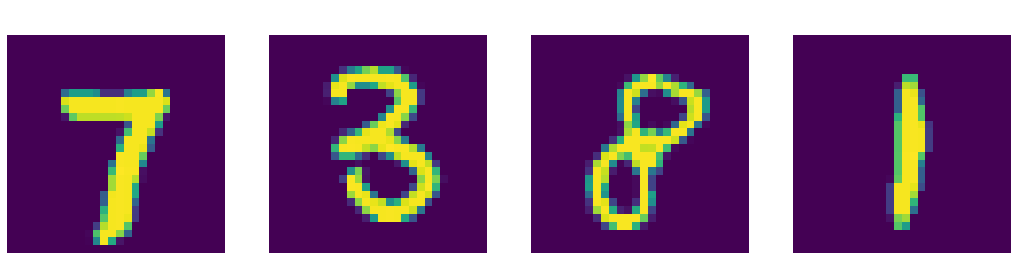

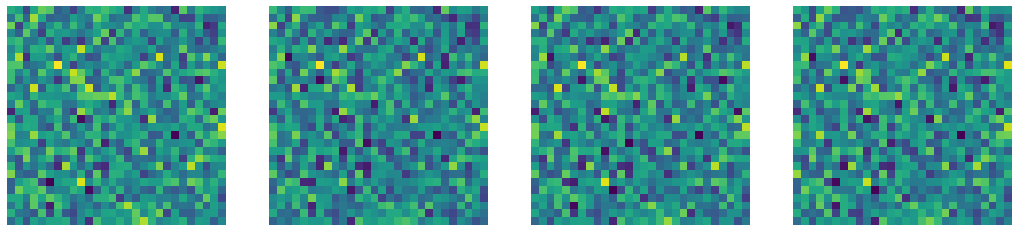

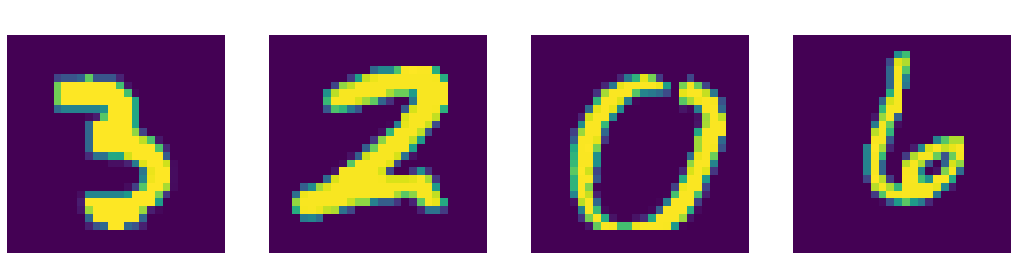

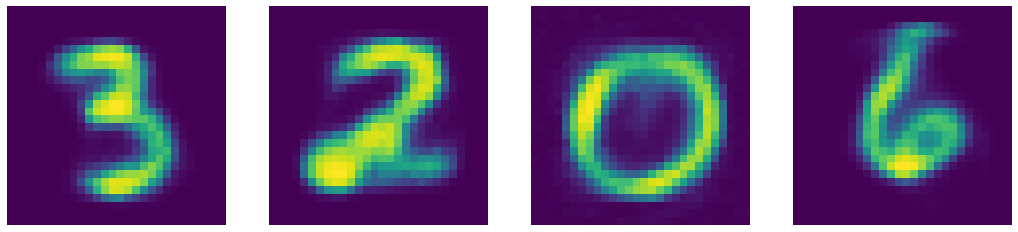

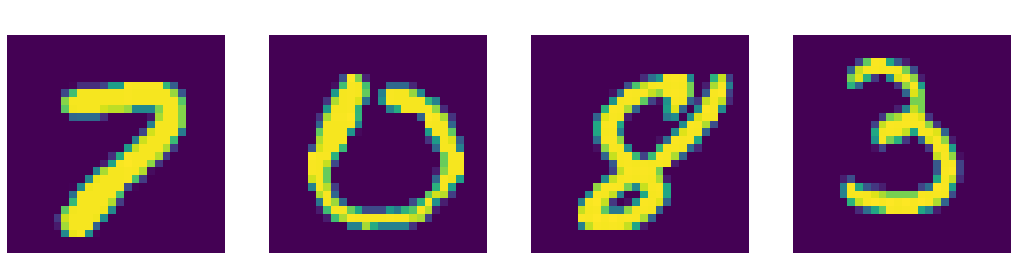

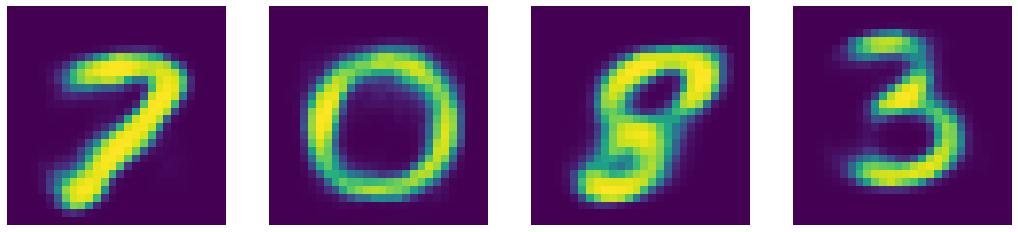

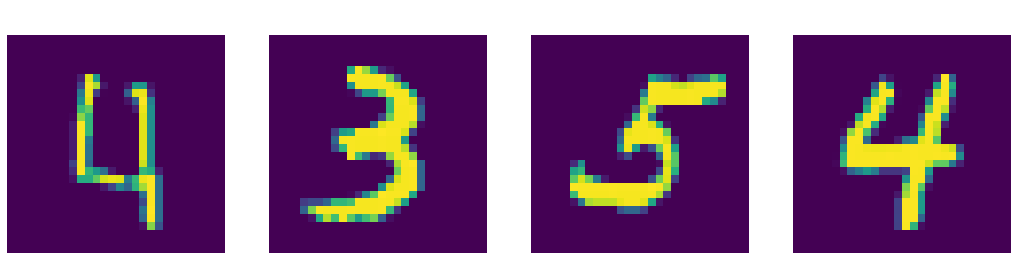

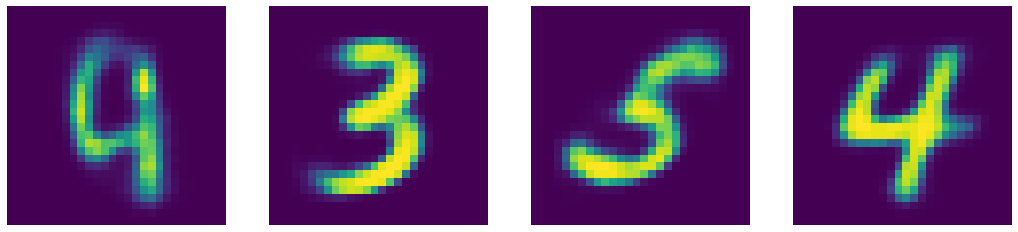

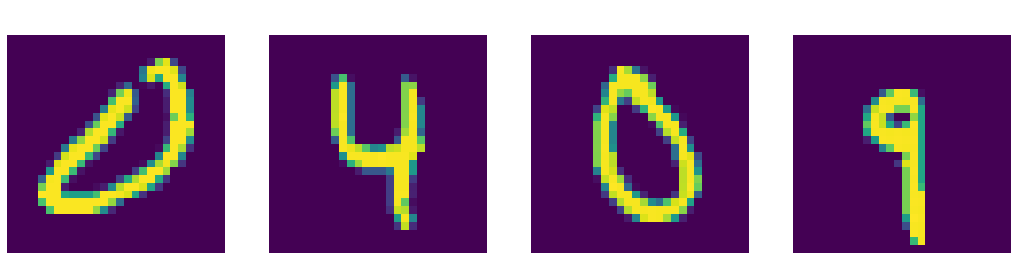

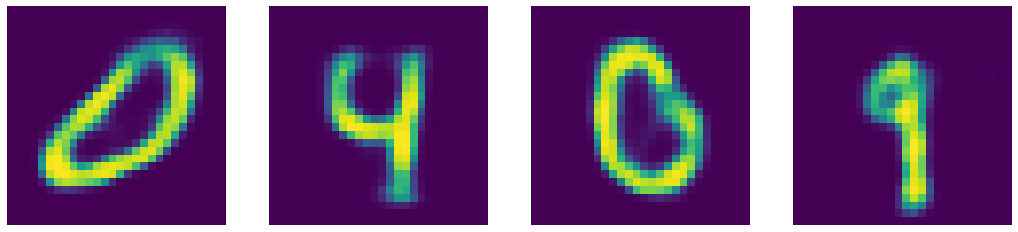

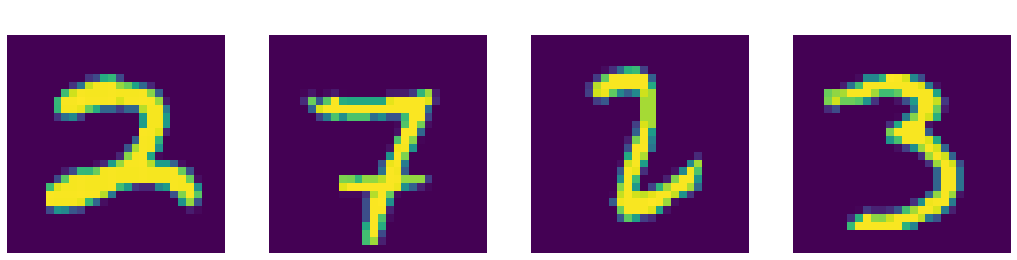

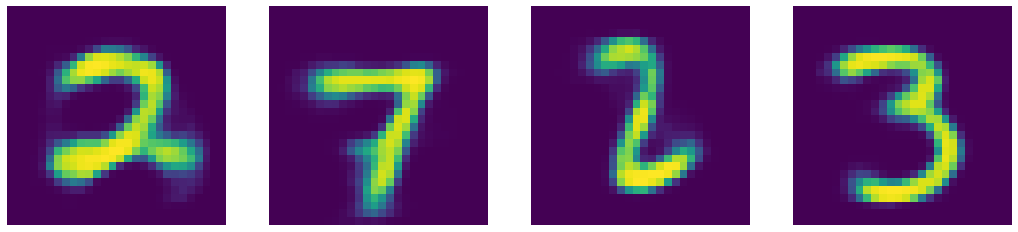

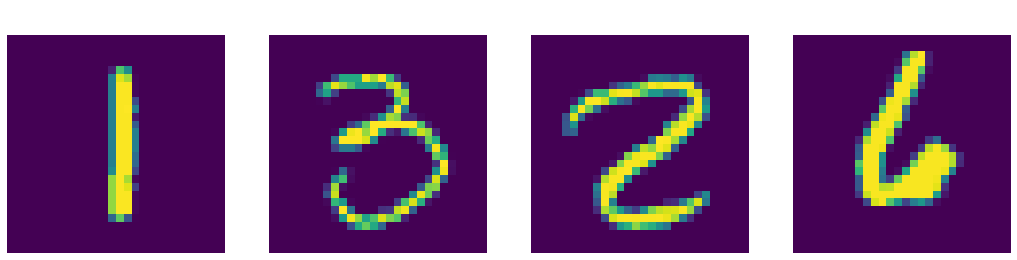

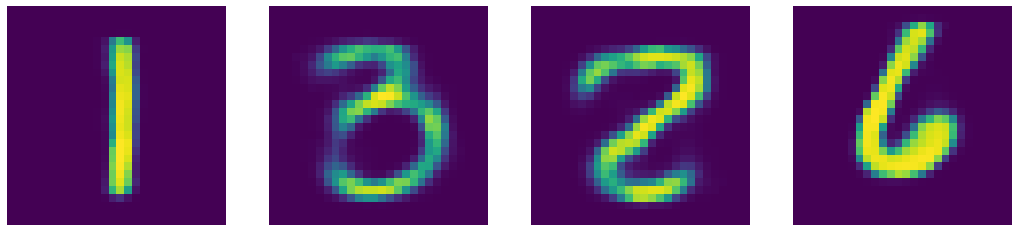

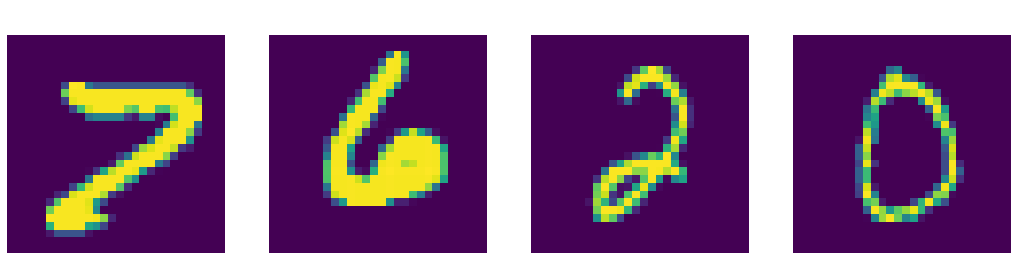

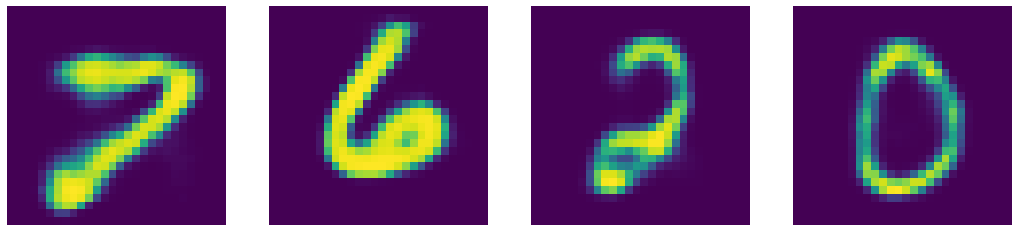

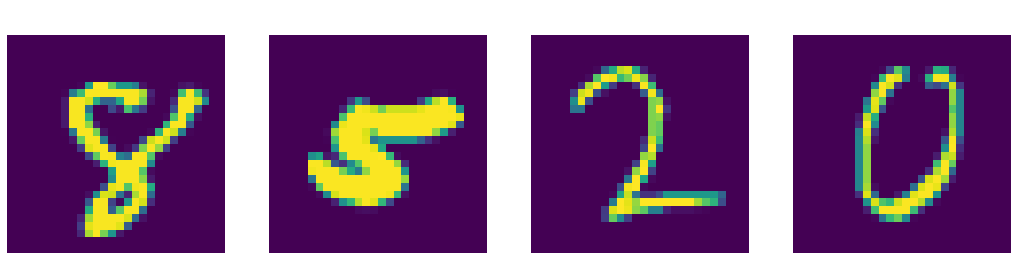

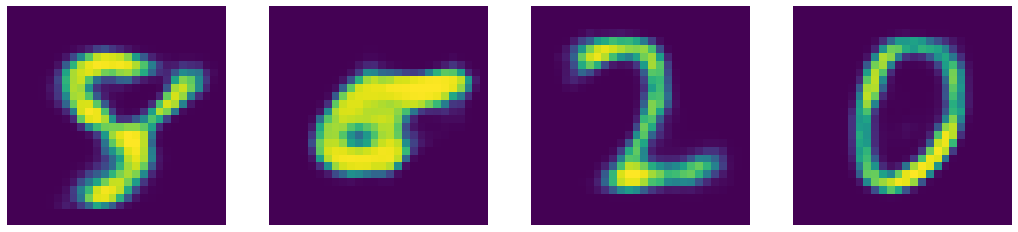

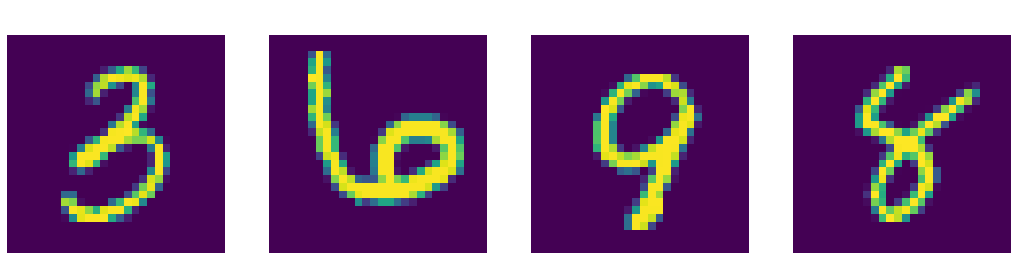

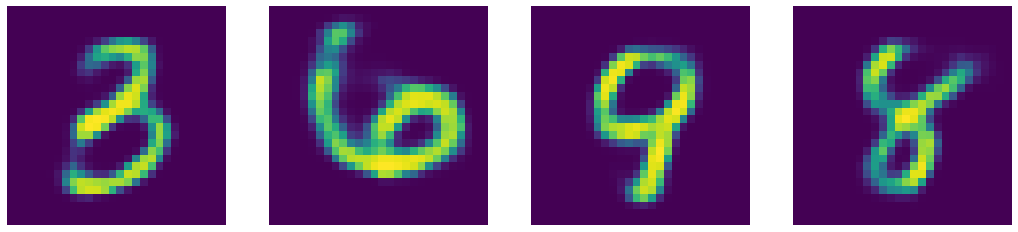

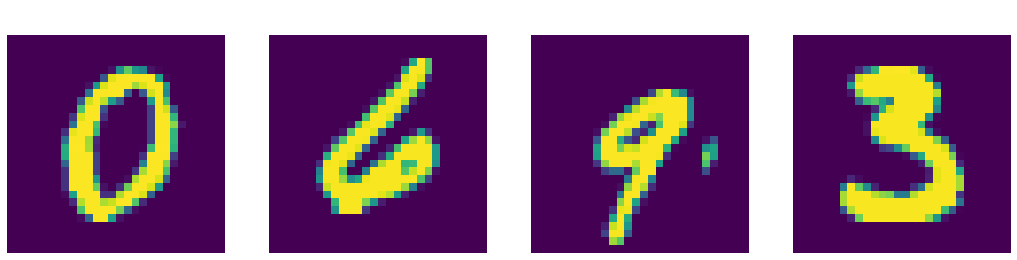

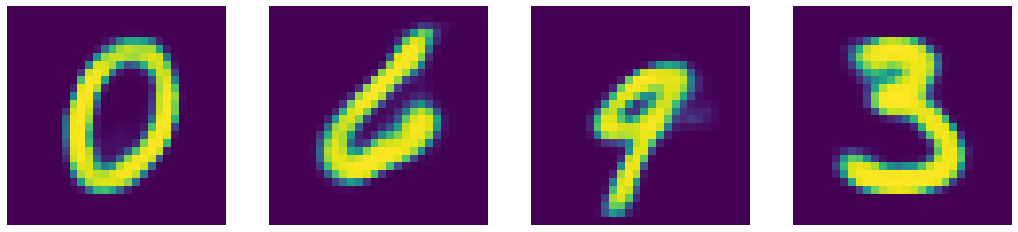

In [12]:
# Training and testing the VAE

epochs = 10
Trainer = VAEt.Trainer(model, optimizer, loss_function, device, train_loader, test_loader, epochs = epochs)
_, codes = Trainer.train()

In [13]:
for x, y in test_loader:
    x = x.to(device)
    x_hat, mu, logvar = model(x)
    pass

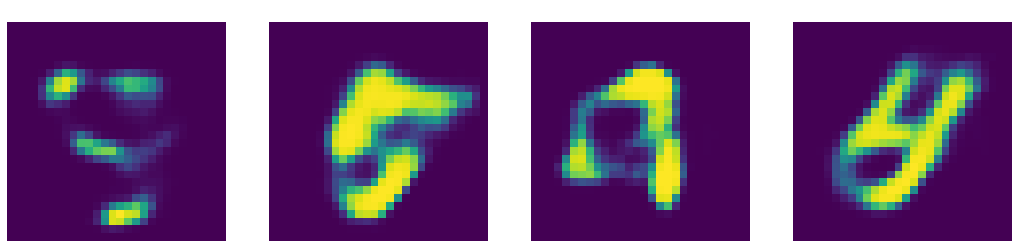

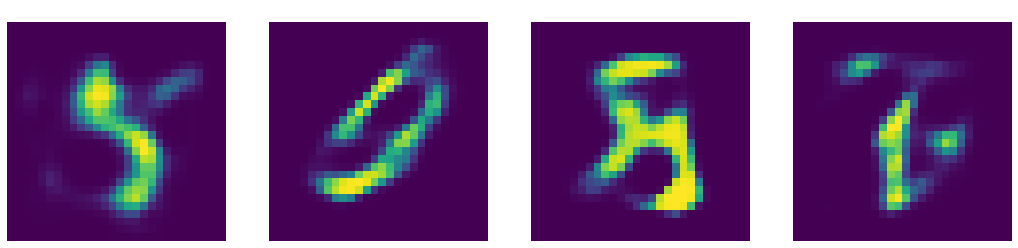

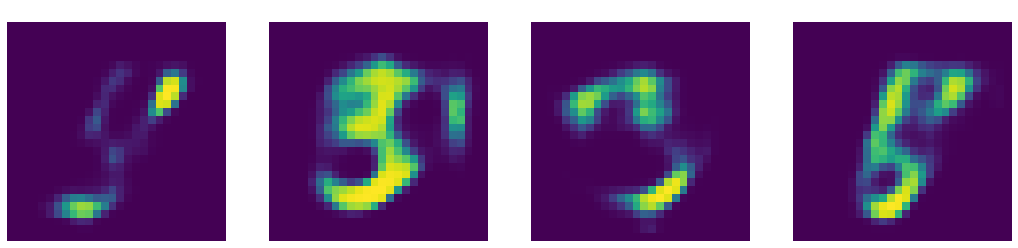

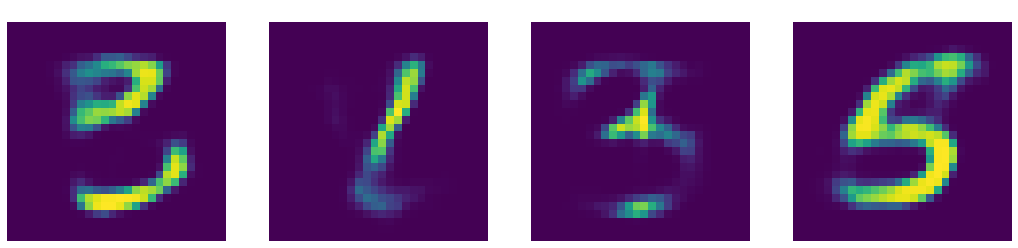

In [14]:
# Generating a few samples

N = 16
z = torch.randn((N, d)).to(device)
sample = model.decoder(z)
display_images(None, sample, N // 4, count=True)

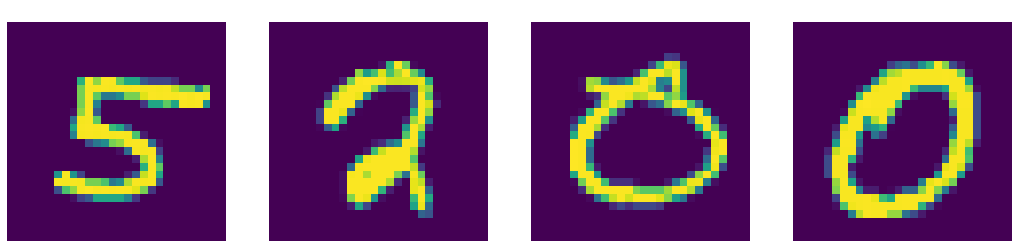

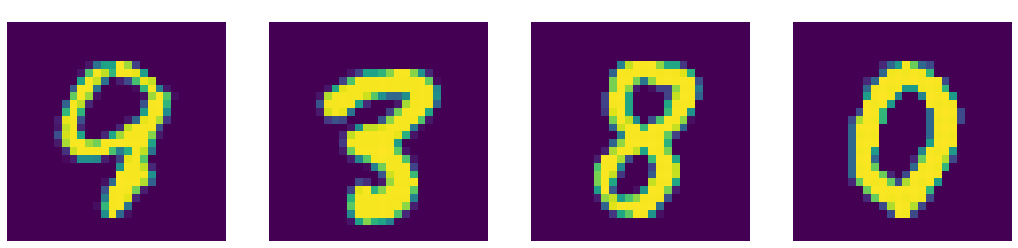

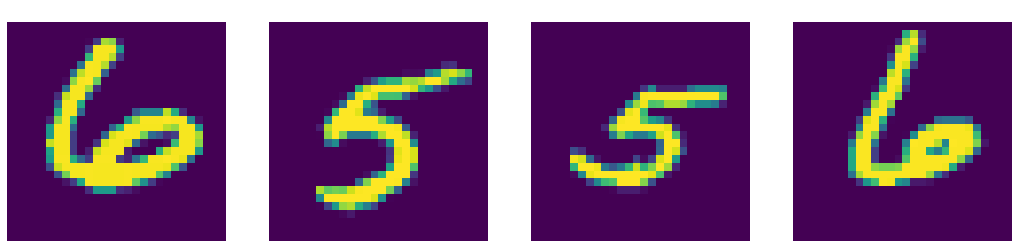

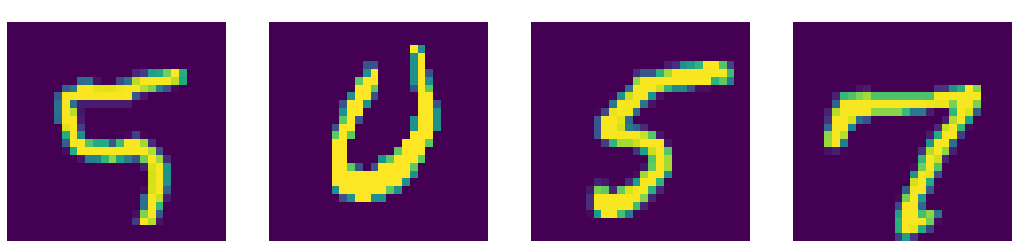

In [15]:
# Display last test batch

display_images(None, x, 4, count=True)

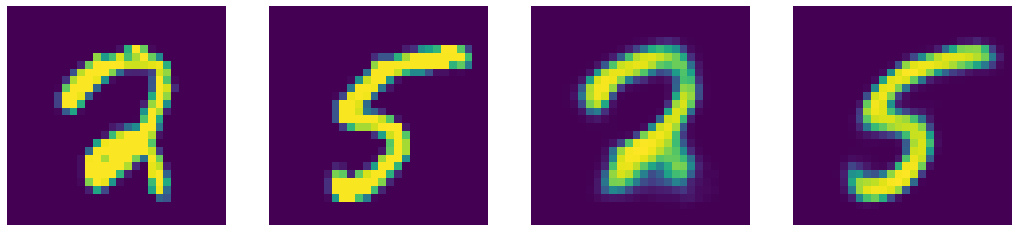

In [16]:
# Choose starting and ending point for the interpolation -> shows original and reconstructed

A, B = 1, 14
sample = model.decoder(torch.stack((mu[A].data, mu[B].data), 0))
display_images(None, torch.stack(((
    x[A].data.view(-1),
    x[B].data.view(-1),
    sample.data[0],
    sample.data[1]
)), 0))

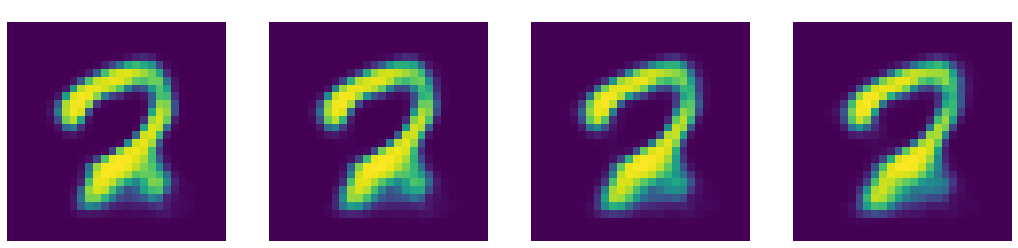

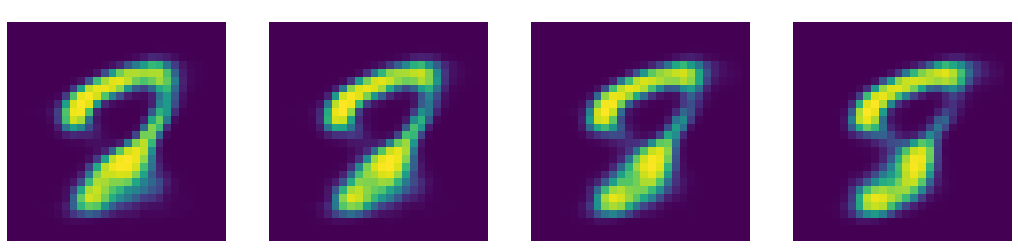

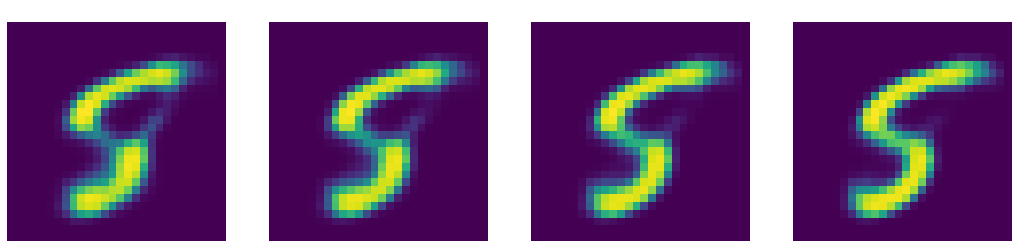

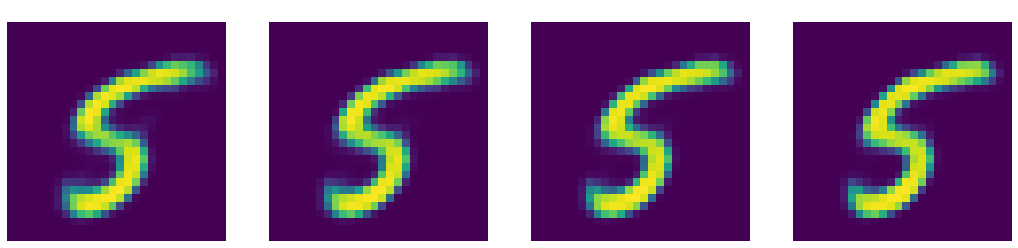

In [17]:
# Perform an interpolation between input A and B, in N steps

N = 16
code = torch.Tensor(N, 20).to(device)
sample = torch.Tensor(N, 28, 28).to(device)
for i in range(N):
    code[i] = i / (N - 1) * mu[B].data + (1 - i / (N - 1) ) * mu[A].data
    # sample[i] = i / (N - 1) * x[B].data + (1 - i / (N - 1) ) * x[A].data
sample = model.decoder(code)
display_images(None, sample, N // 4, count=True)

In [18]:
set_default(figsize=(15, 4))

In [19]:
X, Y, E, losses = list(), list(), list(), list()  # input, classes, embeddings
N = 1000  # samples per epoch
epochs = (0, 5, 10)
for epoch in epochs:
    X.append(codes['μ'][epoch][:N])
    E.append(TSNE(n_components=2).fit_transform(X[-1]))
    Y.append(codes['y'][epoch][:N])
    losses.append(codes['loss'][epoch][:N])

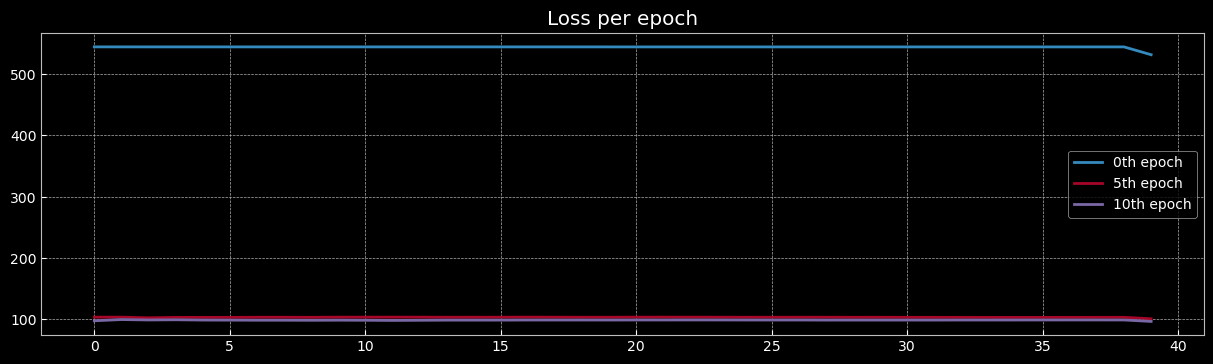

In [20]:
for i, epoch in enumerate(epochs):
	plt.plot(losses[i], label=f"{epoch}th epoch")
plt.legend()
plt.title("Loss per epoch")
plt.show()

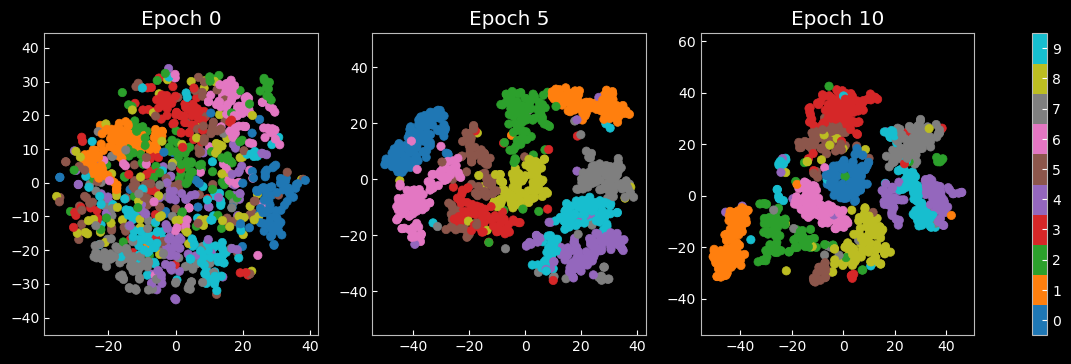

In [21]:
f, a = plt.subplots(ncols=3)
for i, e in enumerate(epochs):
    s = a[i].scatter(E[i][:,0], E[i][:,1], c=Y[i], cmap='tab10')
    a[i].grid(False)
    a[i].set_title(f'Epoch {e}')
    a[i].axis('equal')
f.colorbar(s, ax=a[:], ticks=np.arange(10), boundaries=np.arange(11) - .5)

# Variational Autoencoder with dense decoder

In [22]:
from models import VAE_with_dense_decoder as VAE_ddm
from trainer import VAE_with_dense_decoder as VAE_ddt

In [23]:
d = 20
model_with_dense_decoder = VAE_ddm.Model(d=d, model=model).to(device)

loss_function = VAE_ddm.loss_function(f=nn.functional.binary_cross_entropy, β=0)

learning_rate = 1e-3
optimizer = VAE_ddm.optimizer(model_with_dense_decoder, learning_rate=learning_rate)

In [24]:
epochs = 3
Trainer_with_dense_decoder = VAE_ddt.Trainer(model_with_dense_decoder, optimizer, loss_function, device, train_loader, test_loader, epochs = epochs)
codes_with_dense_decoder = Trainer_with_dense_decoder.train()

====> Test set loss: 3.2647	 Accuracy rate: 2%
---
====> Epoch: 1 Average loss: 0.6177	 Accuracy rate: 89%
====> Test set loss: 0.2420	 Accuracy rate: 16%
---
====> Epoch: 2 Average loss: 0.2880	 Accuracy rate: 95%
====> Test set loss: 0.1803	 Accuracy rate: 16%
---
====> Epoch: 3 Average loss: 0.2422	 Accuracy rate: 96%
====> Test set loss: 0.1497	 Accuracy rate: 16%


tensor([5, 2, 0, 0, 9, 3, 8, 0, 6, 5, 5, 6, 5, 0, 5, 7])
tensor([5, 2, 0, 0, 9, 3, 8, 0, 6, 5, 5, 6, 5, 0, 5, 7], device='cuda:0')


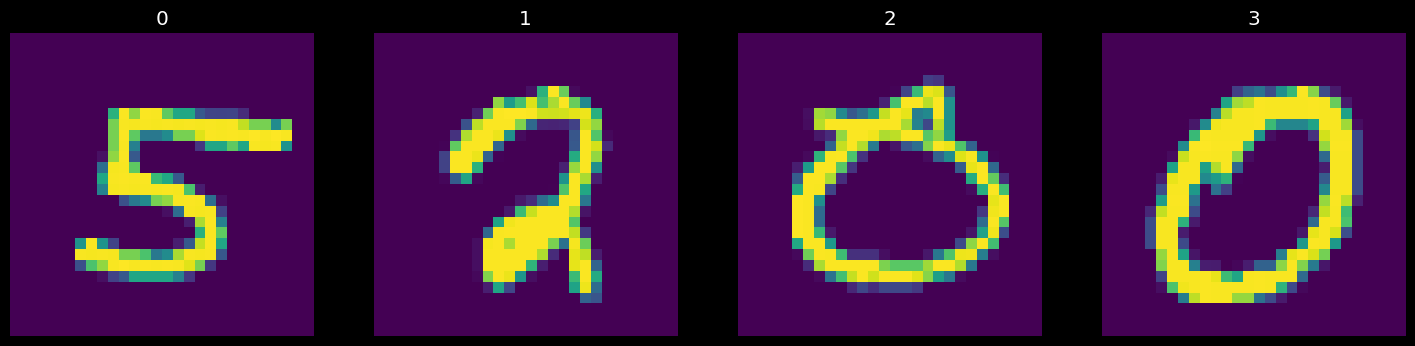

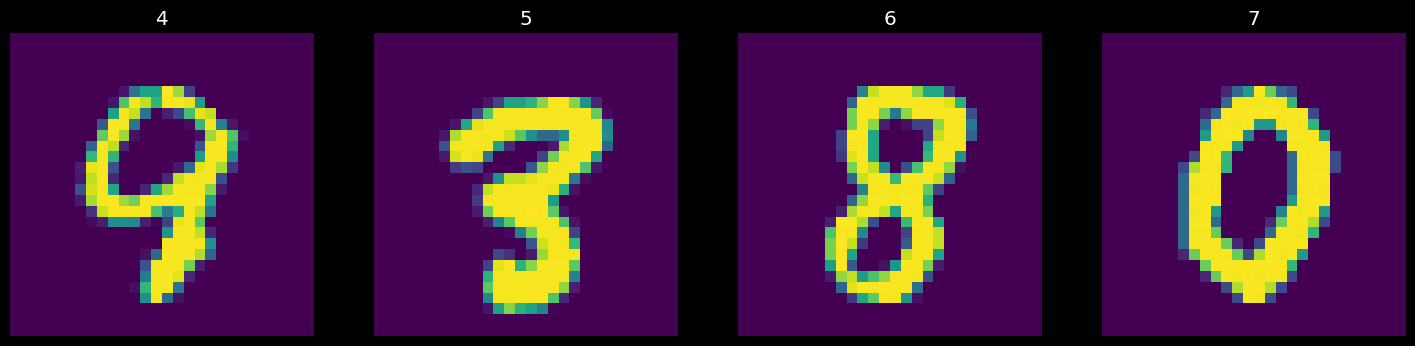

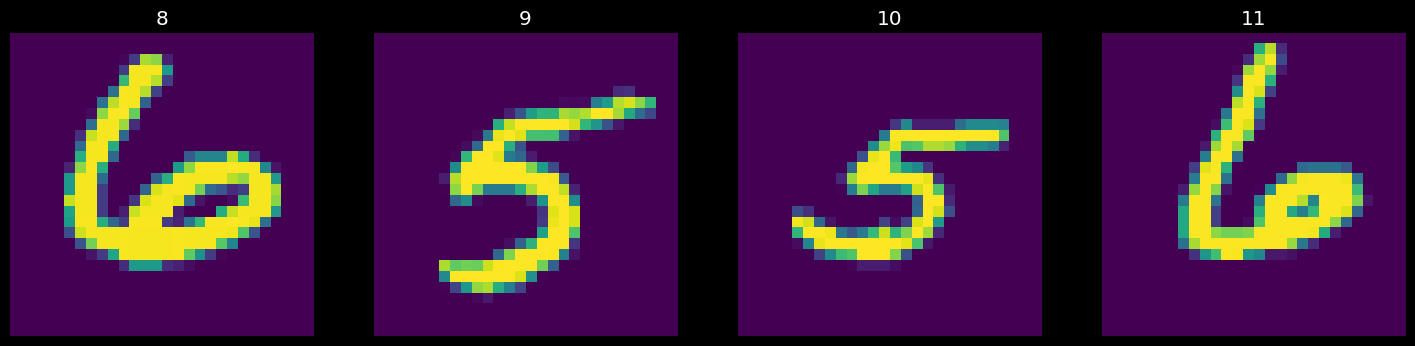

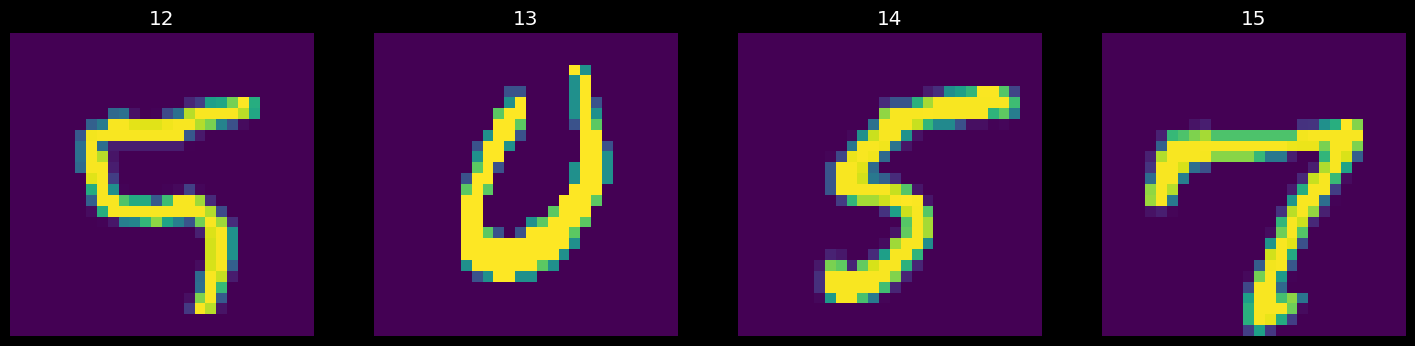

In [25]:
display_images(None, x, 4, count=True)
print(y)
y_hat = model_with_dense_decoder(x)[0]
print(torch.argmax(y_hat, dim=1))

In [26]:
codes = codes_with_dense_decoder[1]
X, Y, E, losses, AR = list(), list(), list(), list(), list()  # input, classes, embeddings
N = 1000  # samples per epoch
epochs = range(epochs)
for epoch in epochs:
    X.append(codes['μ'][epoch][:N])
    E.append(TSNE(n_components=2).fit_transform(X[-1]))
    Y.append(codes['y'][epoch][:N])
    losses.append(codes['loss'][epoch][:N])
    AR.append(codes['AR'][epoch][:N])

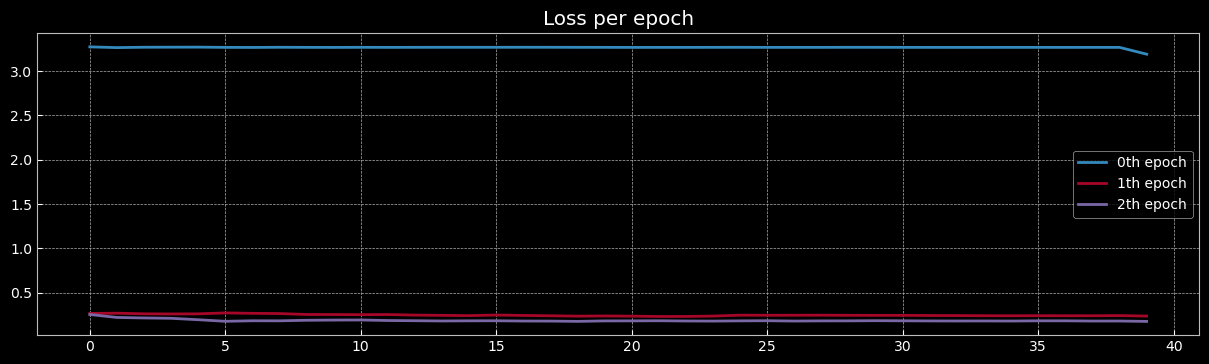

In [27]:
for i, epoch in enumerate(epochs):
	plt.plot(losses[i], label=f"{epoch}th epoch")
plt.legend()
plt.title("Loss per epoch")
plt.show()

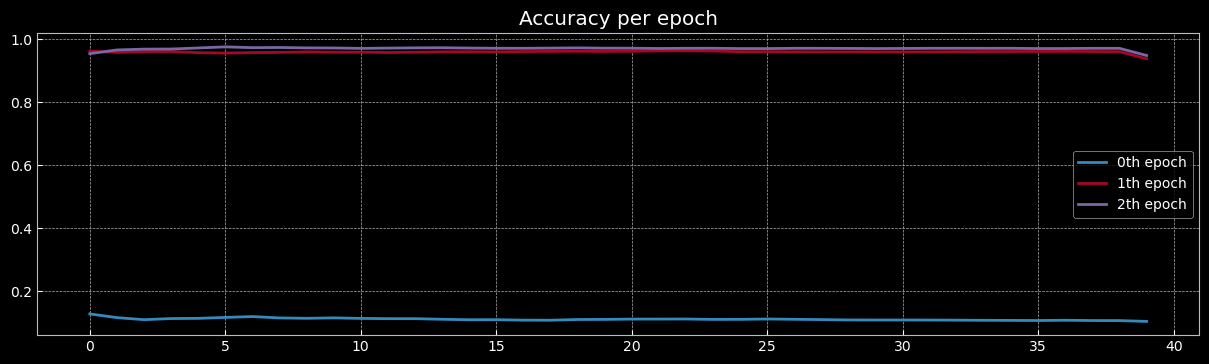

In [28]:
for i, epoch in enumerate(epochs):
	plt.plot(AR[i], label=f"{epoch}th epoch")
plt.legend()
plt.title("Accuracy per epoch")
plt.show()